Проектная работа: "Поиск аномалий во временных рядах данных DWH"

На работе моей работе в BI каждое утро всех волнует вопрос - а что у нас будет происходить с данными? 
И основной из них, прошли ли загрузки успешно и были ли аномалии в данных?
Чаще всего источниками проблем являются следующие факторы: 
1) Внешние ошибки в загрузке (сетевой сбой)
2) Внутренние ошибки в расчетах (изменили алгоритм загрузки, перестало грузиться или стало грузиться, но не верно)
3) Изменился источник данных

Мне была поставлена задача: 
 1) Ловить как можно раньше аномалии в загрузке и расчетах, чтобы успевать поправить до того, как увидит бизнес
 2) Маштабируемое решения под любые новые данные
 3) Не замедлять основной расчет
 4) Быстрое решение за неделю

На старте выбрали 66 наиболее значимых объектов из ~1000 для старта проверки

В данной работе рассмотрим несколько наборов наиболее интересных данных

In [1]:
#Импортирование необходимых библиотек
from datetime import date
import holidays
import ibm_db as db
import pandas as pd
import numpy as np
import seaborn as sns
import time
from datetime import datetime
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from fbprophet import Prophet

In [2]:
#Посмотрим заранее собранные таким способом данные
data = pd.read_csv('test1.csv', delimiter=';')

Перед анализом любых данных нужно провести EDA

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CHECK_ELEM  22 non-null     float64
 1   DATE        22 non-null     object 
dtypes: float64(1), object(1)
memory usage: 480.0+ bytes


In [4]:
data.head()

,CHECK_ELEM,DATE
0,4.323421e+07,2021-01-24
1,1.640051e+08,2021-01-25
2,1.333714e+08,2021-01-26
3,1.211146e+08,2021-01-27
4,1.148973e+08,2021-01-28


In [5]:
df = pd.DataFrame(data.copy())
df['DATE'] = pd.to_datetime(df['DATE'])
df = df.set_index('DATE')
df.head()

,CHECK_ELEM
DATE,
2021-01-24,4.323421e+07
2021-01-25,1.640051e+08
2021-01-26,1.333714e+08
2021-01-27,1.211146e+08
2021-01-28,1.148973e+08


Так как выборку делала сама, то пропусков и дублей нет смысла смотреть, а вот график распределения посмотрим

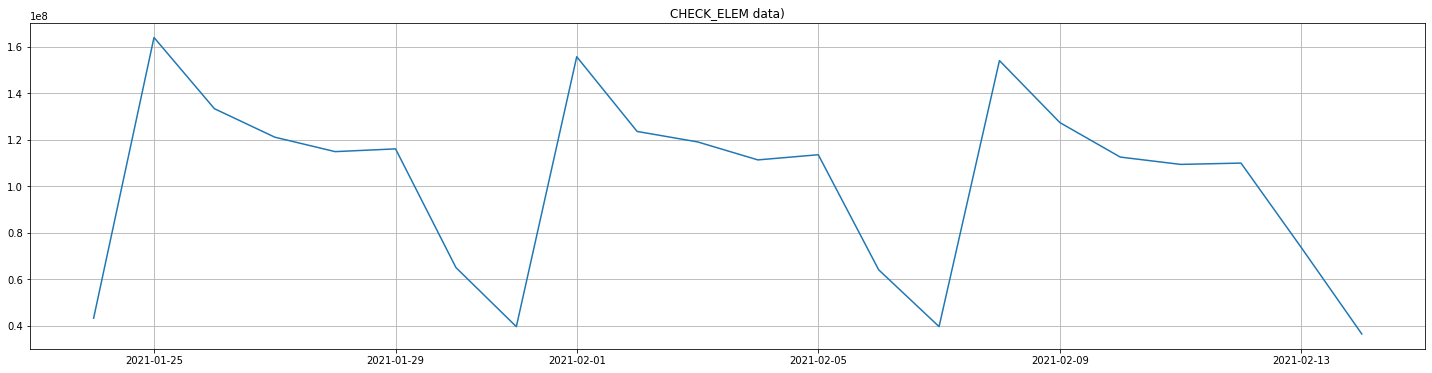

In [6]:
plt.figure(figsize=(25, 6))
plt.plot(df.CHECK_ELEM)
plt.title('CHECK_ELEM data)')
plt.grid(True)
plt.show()

Из графика видно четкую недельную сезонность и легкий тренд. перепады между буднями и выходными сильные, поэтому моделирование с наивным предположением - "завтра будет, также как вчера", что будущее значение переменной зависит от среднего или медианы её предыдущих значений - скользящей средней даст сильные выбросы в выходные и первый рабочий день. Эту гипотезу легко проверить. Пройдемся по некоторым из способов и посмотрим, что мы можем вытащить из нашего временного ряда с рекламой

Метрики качества прогноза
- [R squared](http://scikit-learn.org/stable/modules/model_evaluation.html#r2-score-the-coefficient-of-determination), коэффициент детерминации (в эконометрике - доля объясненной моделью дисперсии), $(-\infty, 1]$
- [Mean Absolute Error](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-absolute-error), интерпретируемая метрика, измеряется в тех же единицах, что и исходный ряд, $[0, +\infty)$
- [Median Absolute Error](http://scikit-learn.org/stable/modules/model_evaluation.html#median-absolute-error), также интерпретируемая метрика, однако её преимущество - нечувствительность (робастность) к выбросам в данных, $[0, +\infty)$
- [Mean Squared Error](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-error), используется в большинстве случаев, сильнее наказывает модель за большие ошибки и меньше - за маленькие (парабола), $[0, +\infty)$
- [Mean Squared Logarithmic Error](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-logarithmic-error), практически тоже самое, но значения предварительно логарифмируются, таким образом маленьким ошибкам также уделяется значительное внимание, обычно используется, если данным присущ экспоненциальный рост, $[0, +\infty)$
- Mean Absolute Percentage Error, как MAE, только в процентах, - удобно для объяснения заказчику качества прогноза, $[0, +\infty)$

Метрики качества прогноза позволяют измерить качество прогноза и объяснить содеянное заказчику 

In [7]:
# импортируем метрики качества
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return int(np.mean(np.abs((y_true - y_pred) / y_true)) * 100)

Отложим значение последнего дня проверки прогноза.

In [8]:
y_test = int(df.tail(1)['CHECK_ELEM'])
y_test

36462452

In [9]:
df.drop(df.tail(1).index,inplace=True)

Начнем моделирование с наивного предположения - "завтра будет, как вчера" - скользящее среднее.

In [10]:
def moving_average(series, n):
    return int(np.average(series[-n:]))

y_pred = moving_average(df['CHECK_ELEM'], 7)
mean_absolute_percentage_error(y_test, y_pred)

184

In [11]:
#Выходит за 50% что не подходит для данной задачи

In [12]:
rolling_mean = df.rolling(window=7).mean()
y_pred = int(rolling_mean.tail(1)['CHECK_ELEM'])
mean_absolute_percentage_error(y_test, y_pred)

184

In [13]:
def plotMovingAverage(series, n, plot_bounds=False):

    """
    series - dataframe with timeseries
    n - rolling window size 
    plot_bounds: bool - whether to draw confidence interval
    """

    rolling_mean = series.rolling(window=n).mean()

    fig, ax = plt.subplots(figsize=(15, 5))
    plt.title("Moving average\n window size = {}".format(n))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # При желании, можно строить и доверительные интервалы для сглаженных значений
    if plot_bounds:
        rolling_std = series.rolling(window=n).std()
        upper_bound = rolling_mean + 1.96 * rolling_std
        lower_bound = rolling_mean - 1.96 * rolling_std
        plt.plot(upper_bound, "r--", label="Upper Bound / Lower Bound")
        plt.plot(lower_bound, "r--")
    plt.plot(series[n:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)
    # Деления соответствуют понедельникам что дает представление о недельной цикличности графика
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MONDAY))
    # Отображать значение дат в формате yy-mm-dd
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%y-%m-%d"))
    plt.xticks(rotation=45)

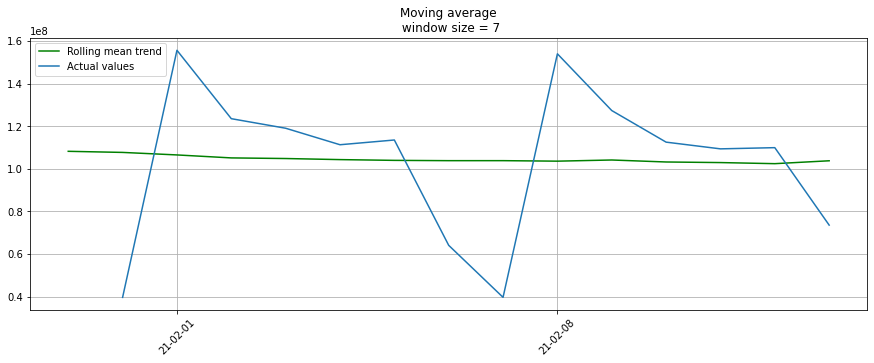

In [14]:
plotMovingAverage(df, 7)  # сглаживаем по неделям

модели Хольта-Винтерса - нет из-за большого кол-ва параметров, затача прогнозировать на 1 день не стоит таких затрат

SARIMA - сложная в настройке

Временной ряд существенно отличается от простой выборки данных, так как при анализе учитывается взаимосвязь измерений со временем, а не только статистическое разнообразие и статистические характеристики выборки (Источник Википедия).
Тоесть данные упорядочены относительно неслучайных моментов времени, значит, могут содержать в себе дополнительную информацию, которую можно извлечь.
Так как мы смотрим на 3 недели назад полезным будет. День недели, признак праздника, признак выходного дня

In [15]:
#Генерируем признаки, разбиваем на треин и тест
def prepareData(df, test_index=21):
    data = pd.DataFrame(df.copy())
    data['DATE'] = pd.to_datetime(data['DATE'])
    data = data.set_index('DATE')
    data.columns = ["y"]
    
    data["weekday"] = data.index.weekday
    data["is_weekend"] = data.weekday.isin([5, 6]) * 1
    for _date in data.index:
        if _date.date() in holidays.RU():
            data["is_holiday"] = 1
        else:
            data["is_holiday"] = 0

    data = data.dropna()
    data = data.reset_index(drop=True)
    
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index-1].drop(["y"], axis=1)
    y_train = data.loc[:test_index-1]["y"]
    X_test = data.loc[test_index:].drop(["y"], axis=1)
    y_test = data.loc[test_index:]["y"]
    
    return X_train, X_test, y_train, y_test

In [16]:
def LR(data, test_index=21):
    X_train, X_test, y_train, y_test = prepareData(data)
    lr = LinearRegression()
    lr.fit(X_train, y_train)

    # посмотрим, как модель вела себя на тренировочном отрезке ряда
    prediction_train = lr.predict(X_train)
    
    lower = prediction_train - prediction_train * 0.5
    upper = prediction_train + prediction_train * 0.5
    
    Anomalies = np.array([np.NaN] * len(y_train))
    Anomalies[y_train < lower] = y_train[y_train < lower]

    plt.figure(figsize=(15, 5))
    plt.plot(prediction_train, label="prediction train")
    plt.plot(y_train, label="y_train")
    plt.plot(lower, "r--", label="upper bond / lower bond")
    plt.plot(upper, "r--")
    plt.plot(Anomalies, "ro", markersize=10)
    plt.title(
        "Train mean absolute error {}".format(
            round(mean_absolute_error(prediction_train, y_train))
        )
    )
    plt.legend(loc="best")
    plt.axis("tight")
    plt.grid(True)
    plt.legend()


    prediction = lr.predict(X_test)
    
    print('Test {}'.format(int(y_test)))
    print('Prediction {}'.format(int(prediction)))
    lower = prediction - prediction * 0.5
    upper = prediction + prediction * 0.5
    if int(y_test)<lower or int(y_test)> upper:
         print('Anomaly deviation {}%'.format(int((y_test - prediction) / prediction * 100)))
    else: 
        print('No Anomaly deviation {}%'.format(int((y_test - prediction) / prediction * 100)))
    print('Test mean_absolute_percentage_error {}%'.format(mean_absolute_percentage_error(int(y_test), int(prediction))) )

Test 36462452
Prediction 48520229
No Anomaly deviation -24%
Test mean_absolute_percentage_error 33%


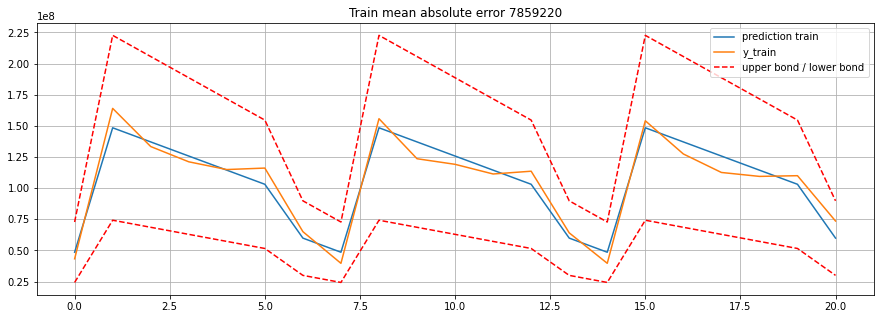

In [17]:
LR(data)

In [18]:

def performTimeSeriesCV(X_train, y_train, number_folds, model, metrics):
    print("Size train set: {}".format(X_train.shape))

    k = int(np.floor(float(X_train.shape[0]) / number_folds))
    print("Size of each fold: {}".format(k))

    errors = np.zeros(number_folds - 1)

    # loop from the first 2 folds to the total number of folds
    for i in range(2, number_folds + 1):
        print()
        split = float(i - 1) / i
        print(
            "Splitting the first " + str(i) + " chunks at " + str(i - 1) + "/" + str(i)
        )

        X = X_train[: (k * i)]
        y = y_train[: (k * i)]
        print(
            "Size of train + test: {}".format(X.shape)
        )  # the size of the dataframe is going to be k*i

        index = int(np.floor(X.shape[0] * split))

        # folds used to train the model
        X_trainFolds = X[:index]
        y_trainFolds = y[:index]

        # fold used to test the model
        X_testFold = X[(index + 1) :]
        y_testFold = y[(index + 1) :]

        model.fit(X_trainFolds, y_trainFolds)
        errors[i - 2] = metrics(model.predict(X_testFold), y_testFold)

    # the function returns the mean of the errors on the n-1 folds
    return errors.mean()

28% много конечно, но лучше чем средняя 

In [19]:
X_train, X_test, y_train, y_test = prepareData(data)
lr = LinearRegression()
lr.fit(X_train, y_train)
performTimeSeriesCV(X_train, y_train, 3, lr, mean_absolute_percentage_error)

Size train set: (21, 3)
Size of each fold: 7

Splitting the first 2 chunks at 1/2
Size of train + test: (14, 3)

Splitting the first 3 chunks at 2/3
Size of train + test: (21, 3)


7.5

На 3 фолдах получила средний % ошибки в 7.5 что для поиска аномалий подходит

XGBoost

In [20]:
import xgboost as xgb


def XGB_forecast(data, scale=1.96):

    # исходные данные
    X_train, X_test, y_train, y_test = prepareData(data)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test)

    # задаём параметры
    params = {"objective": "reg:linear", "booster": "gblinear"}
    trees = 1000

    # прогоняем на кросс-валидации с метрикой rmse
    cv = xgb.cv(
        params,
        dtrain,
        metrics=("rmse"),
        verbose_eval=False,
        nfold=10,
        show_stdv=False,
        num_boost_round=trees,
    )

    # обучаем xgboost с оптимальным числом деревьев, подобранным на кросс-валидации
    bst = xgb.train(params, dtrain, num_boost_round=cv["test-rmse-mean"].argmin())

    # можно построить кривые валидации
    # cv.plot(y=['test-mae-mean', 'train-mae-mean'])

    # запоминаем ошибку на кросс-валидации
    deviation = cv.loc[cv["test-rmse-mean"].argmin()]["test-rmse-mean"]

    # посмотрим, как модель вела себя на тренировочном отрезке ряда
    prediction_train = bst.predict(dtrain)
    
#    lower = prediction_train - scale * deviation
#    upper = prediction_train + scale * deviation

    lower = prediction_train - prediction_train*0.5
    upper = prediction_train + prediction_train*0.5
    
    Anomalies = np.array([np.NaN] * len(y_train))
    Anomalies[y_train < lower] = y_train[y_train < lower]
    
    plt.figure(figsize=(15, 5))
    plt.plot(prediction_train, label="prediction train")
    plt.plot(y_train, label="y_train")
    plt.plot(lower, "r--", label="upper bond / lower bond")
    plt.plot(upper, "r--")
    plt.plot(Anomalies, "ro", markersize=10)
    plt.title(
        "XGBoost Mean absolute error {}".format(
            round(mean_absolute_error(prediction_train, y_train))
        )
    )
    plt.legend(loc="best")
    plt.axis("tight")
    plt.grid(True)
    plt.legend()
    
    prediction_test = bst.predict(dtest)
    print('Test mean_absolute_percentage_error {}%'.format(mean_absolute_percentage_error(int(y_test), int(prediction_test))) )

Test mean_absolute_percentage_error 30%


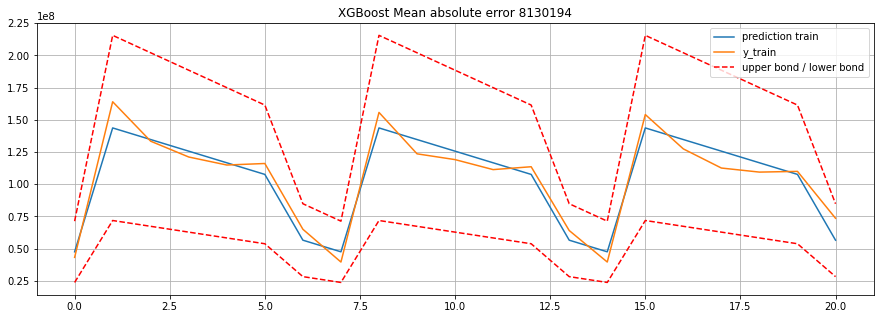

In [21]:
XGB_forecast(data)

Такой же примерно результат как на простой линейной регрессии

Рассмотрим еще пару наборов. Вот эти же данные, но с аномальным значением

In [22]:
data2 = pd.read_csv('test2.csv', delimiter=';')

Test 419060
Prediction 255440
Anomaly deviation 64%
Test mean_absolute_percentage_error 39%


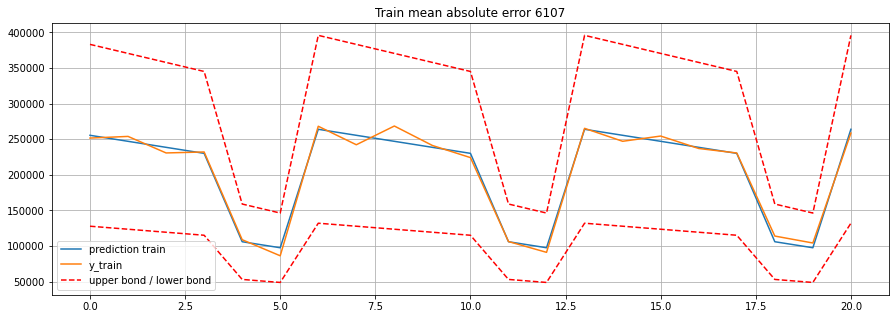

In [23]:
LR(data2)

Facebook Prophet

In [24]:
def ProphetF(df, predictions):
    df.columns = ['y', 'ds']
    train_df = df[:-predictions]
    model = Prophet(weekly_seasonality=True, yearly_seasonality=False)
    model.fit(train_df)
    future = model.make_future_dataframe(periods=predictions, freq='D')
    forecast = model.predict(future)
    # Построим график
    error = mean_absolute_percentage_error(df[-predictions:]['y'], forecast[-predictions:]['yhat'])
    y_test = int(df[-predictions:]['y'])
    prediction = int(forecast[-predictions:]['yhat'])
    print("Mean absolute percentage error {0:.2f}%".format(error))
    print('Test {}'.format(int(y_test)))
    print('Prediction {}'.format(int(prediction)))
    lower = prediction - prediction * 0.5
    upper = prediction + prediction * 0.5
    if int(y_test)<lower or int(y_test)> upper:
         print('Anomaly deviation {}%'.format(int((y_test - prediction) / prediction * 100)))
    else: 
        print('No Anomaly deviation {}%'.format(int((y_test - prediction) / prediction * 100)))
    _ = model.plot(forecast)
    _ = model.plot_components(forecast)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 15.


Mean absolute percentage error 5.00%
Test 36462452
Prediction 38434102
No Anomaly deviation -5%


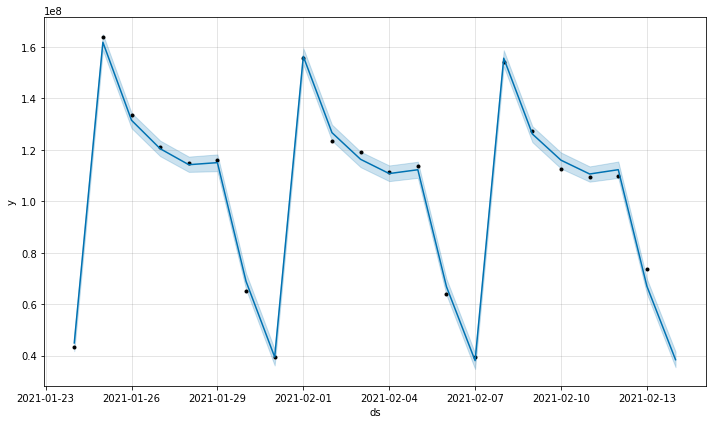

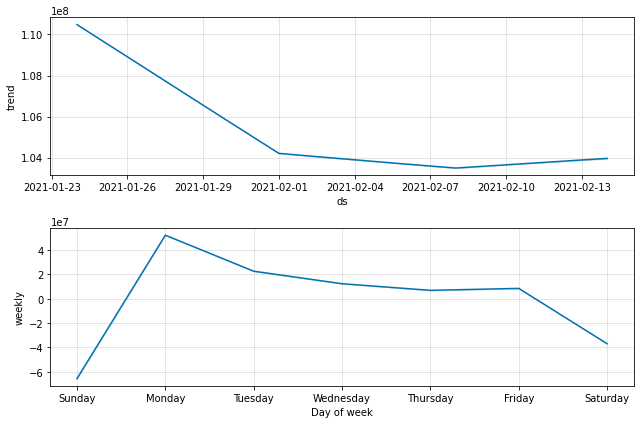

In [25]:
df = data.copy()
df['DATE'] = pd.to_datetime(df['DATE'])
ProphetF(df, 1)

Как видно Prophet показал наилучший результат, угадал тренд и сезонность

## Заключение
В ходе работы над задачей были рассмотренны подходы к анализу и прогнозированию временных рядов. Задача прогнозирования - творческая и исследовательская задача. В прогназировании есть много подходов и выбирать подходящий нужно ориентируясь на цели поставленной задачи. SARIMA-модель хотя и демонстрирует выдающиеся результаты при должной настройке, но она может потребовать не одного часа манипуляций с рядом, в то время как линейную регрессию можно настроить за 10 минут, получив при этом более-менее сравнимые результаты, поэтому на начальном этапе этот вариант нам подошел и позволил за вечер написать механизм, который легко маштабируется, быстро прогоняется и позволяет заранее отлавливать ошибки и отклонения в данных. В данном иследовании Prophet от Facebook подошел наилучшим образом как по простоте, качеству и затраченному времени

Демонстрация того, что было сделано на проекте

Скрипт с тестами запускается на сервере по крону каждую ночь, после расчетов необходимых таблиц. 

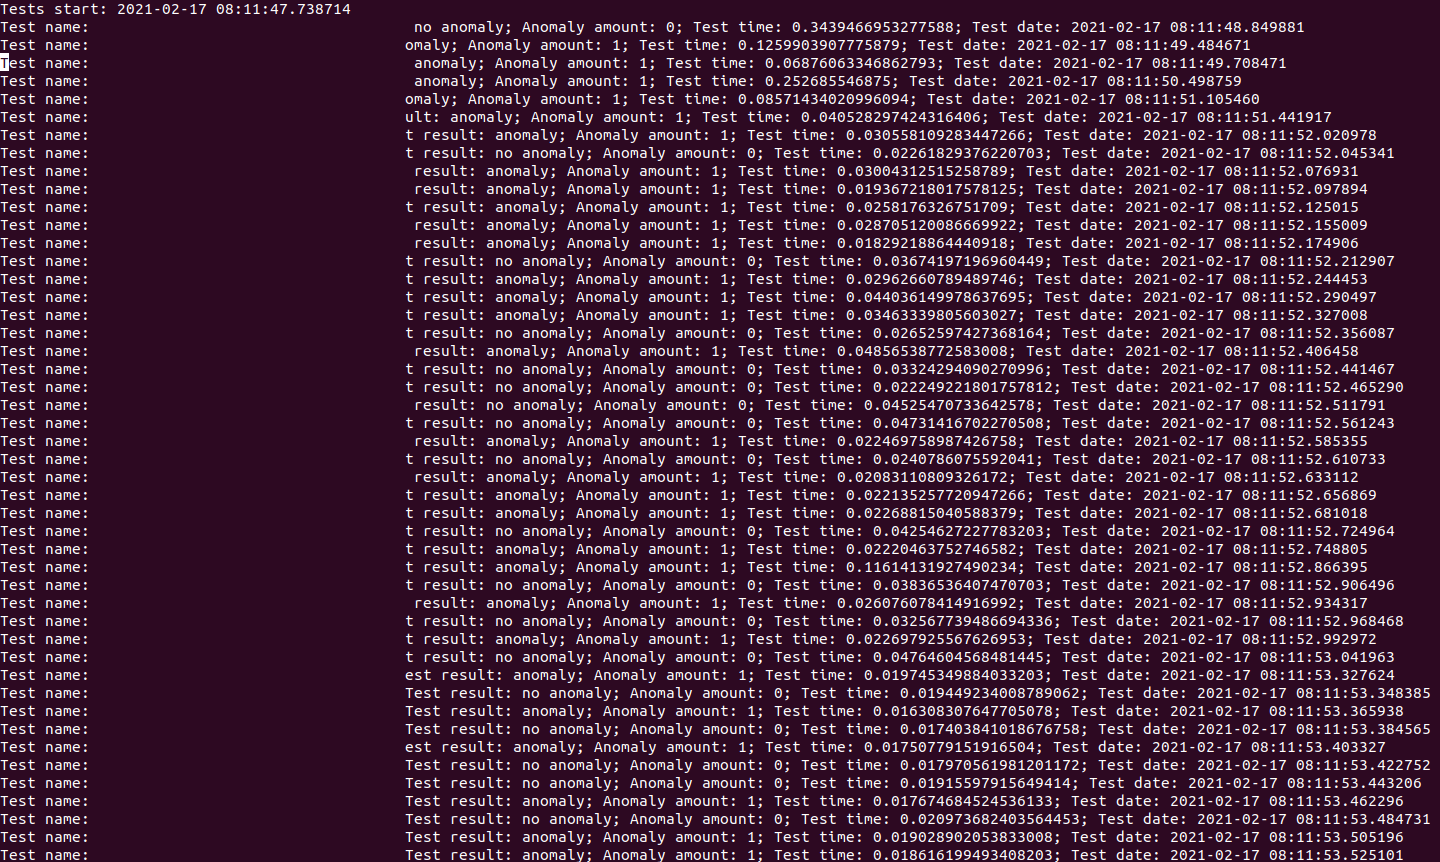

После его окончания на почту команды приходит письмо и ссылка на дашборд с результатами

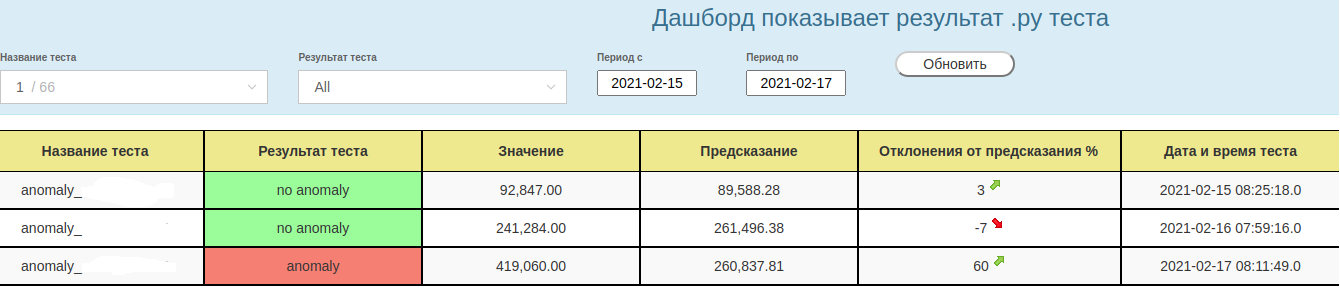

Вот тут действительно была аномалия, после разбора, выяснили, что в системе источника сбой и было частичное задвоение по данным. Мы об этом узназнали заранее, благодаря тестам и смогли предупредить бизнес. Поставленная цель достигнута =)